In [1593]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

# 1. Implement and test observer (Stationary)

## 1.1 Load and parse flight data

Load flight data.

In [1594]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
A = np.array(model['A'])
B = np.array(model['B'])
C = np.array(model['C'])
D = np.array(model['D'])
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']
r_s_eq = model['r_s_eq']

# Show model
A_str = np.array2string(A,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('A = '),
                max_line_width=np.inf)
B_str = np.array2string(B,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('B = '),
                max_line_width=np.inf)
C_str = np.array2string(C,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('C = '),
                max_line_width=np.inf)
D_str = np.array2string(D,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('D = '),
                max_line_width=np.inf)
print('STATE-SPACE MODEL')
print(f'A = {A_str}')
print(f'B = {B_str}')
print(f'C = {C_str}')
print(f'D = {D_str}')
print('PARAMETER VALUES')
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')
print(f'r_s_eq = {r_s_eq:7.4f}')

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A)))
assert(np.all(np.isfinite(B)))
assert(np.all(np.isfinite(C)))
assert(np.all(np.isfinite(D)))

STATE-SPACE MODEL
A = [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [1595]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('follower_test_stationary.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)



# Only look at data from when the drone was actually flying
only_in_flight(data_drone)

Parse flight data. We label state estimates from the drone as `_default` to indicate that they come from the default observer.

In [1596]:
# time
t = data_drone['time']

# state estimates from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']
v_x_default = data_drone['ae483log.v_x']
v_y_default = data_drone['ae483log.v_y']
v_z_default = data_drone['ae483log.v_z']
# r_s_default = data_drone['ae483log.r_s']

Define parameter values.

In [1597]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


## 1.2 Apply observer for gain matrix chosen by equal weights

Implement and run your observer in the following code cell.

For each state, the result will be a numpy array (e.g., `p_x_offline`) that contains a state estimate at every time step. We label state estimates as `_offline` to indicate that they come from a custom observer that has been implemented offline. We also label the arrays of inputs (e.g., `w_x_offline`) and outputs (e.g., `n_x_offline`) as `_offline` to indicate that they are being used by a custom observer that has been implemented offline.

In [1598]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
d_offline = data_drone['ae483log.d']

# Initialize estimates
p_x = p_x_default[0]
p_y = p_y_default[0]
p_z = p_z_default[0]
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
p_x_t = 0.
p_y_t = 0.
p_z_t = 0.
r_s = 0.
r_s_minusone = 0.
r_s_minustwo = 0.

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))
p_x_t_offline = np.zeros(len(t))
p_y_t_offline = np.zeros(len(t))
p_z_t_offline = np.zeros(len(t))
r_s_offline = np.zeros(len(t))
r_s_dot_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d = d_offline[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = k_flow * (v_x / p_z_eq - w_y) - n_x
    n_y_err = k_flow * (v_y / p_z_eq + w_x) - n_y
    r_err = (p_z-p_z_eq) - (r - p_z_eq)
    d_err = r_s - d
    
    # Update estimates
    p_x += dt * v_x
    p_y += dt * v_y
    p_z += dt * (v_z - 24.182550 * r_err)
    p_x_t += dt * v_x
    p_y_t += dt * v_y
    p_z_t += dt * v_z
    # if i == 0:
    if np.abs(d) < 7.:
        r_s_minustwo = r_s_minusone
        r_s_minusone = r_s
        r_s += dt * (- d_err)
    else: 
        r_s = r_s

    r_s_dot = (3. * r_s - 4. * r_s_minusone + r_s_minustwo) / (2. * dt)

    # else:

    psi += dt * w_z
    theta += dt * (w_y - 0.004880 * n_x_err)
    phi += dt * (w_x + 0.007771 * n_y_err)
    v_x += dt * (g * theta - 0.119176 * n_x_err)
    v_y += dt * (-g * phi - 0.149082 * n_y_err)
    v_z += dt * ((a_z - g) - 113.840826 * r_err)
    
    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z
    p_x_t_offline[i] = p_x_t
    p_y_t_offline[i] = p_y_t
    p_z_t_offline[i] = p_z_t
    r_s_offline[i] = r_s
    r_s_dot_offline[i] = r_s_dot

Compute error in each state estimate (relative to state estimates produced by the default observer and logged during the flight test).

In [1599]:
p_x_t_w = -1.2
p_y_t_w = 1.2
p_z_t_w = 0.

p_t_w = np.array([p_x_t_w, p_y_t_w, p_z_t_w])

p_x_t_default = p_x_default - p_x_t_w
p_y_t_default = p_y_default - p_y_t_w
p_z_t_default = p_z_default - p_z_t_w

p_x_t_w_offline = p_x_offline - p_x_t_offline
p_y_t_w_offline = p_y_offline - p_y_t_offline
p_z_t_w_offline = p_z_offline - p_z_t_offline


In [1600]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default
p_x_t_err = p_x_t_offline - p_x_t_w
p_y_t_err = p_y_t_offline - p_y_t_w
p_z_t_err = p_z_t_offline - p_z_t_w


Compare estimates with those produced by (1) the default observer and (2) the motion capture system.

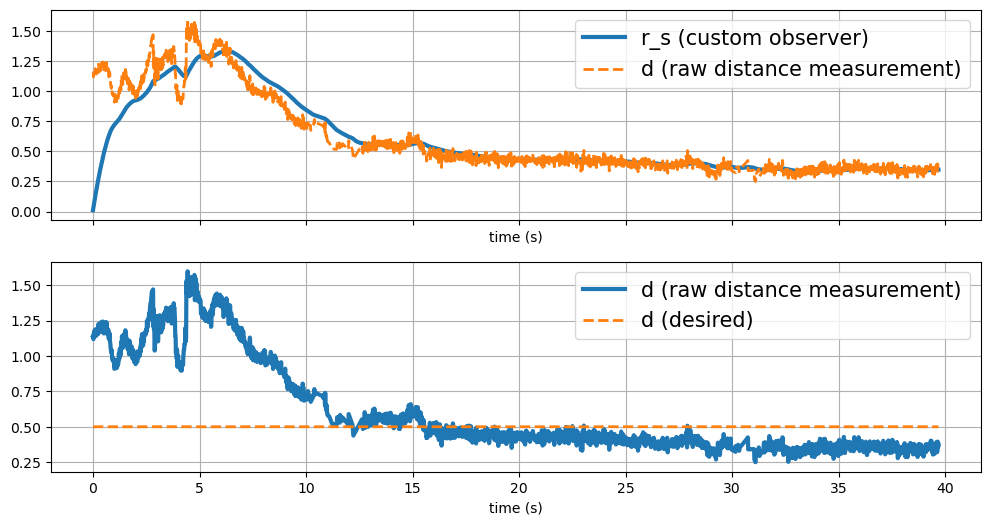

In [1601]:



import matplotlib.pyplot as plt
import numpy as np

def comparison_plot(t, s_offline, s_default, label_offline, label_default, ax, s_mocap=None, xlabel=False):
    # Plot the custom observer data with the given custom label
    ax.plot(t, s_offline, label=label_offline, linewidth=3)
    
    # Set the x-axis label if requested
    if xlabel:
        ax.set_xlabel('time (s)')
    
    # Plot the default/desired data with the given custom label
    ax.plot(t, s_default, '--', label=label_default, linewidth=2)
    
    # Optionally plot motion capture data if provided
    if s_mocap is not None:
        ax.plot(t, s_mocap, ':', label='mocap', linewidth=4)
    
    # Display legend with a larger font size
    ax.legend(fontsize=15)
    
    # Add a grid for better readability
    ax.grid()


# Create a figure with two subplots sharing the x-axis
fig, (ax_r_s, ax_d) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# First subplot:
# r_s_offline is the custom observer data for r_s
# d_offline is the raw distance data for d
comparison_plot(
    t, r_s_offline, d_offline, 
    label_offline='r_s (custom observer)', 
    label_default='d (raw distance measurement)',
    ax=ax_r_s, xlabel=True
)

# Second subplot:
# Here we want to compare d_offline (raw distance data) to a desired constant 0.5 (or 0.8 as previously shown)
desired_value = 0.5
comparison_plot(
    t, d_offline, np.ones(len(t))*desired_value, 
    label_offline='d (raw distance measurement)', 
    label_default='d (desired)',
    ax=ax_d, xlabel=True
)

# Show the figure
plt.show()


Plot error in each state estimate with respect to ground truth.

In [1602]:
np.sqrt(np.mean((r_s_offline[1000:] - 0.5) ** 2)), np.sqrt(np.mean((d_offline[1000:] - 0.5) ** 2))

(0.12289210584085389, 0.1181823814782123)

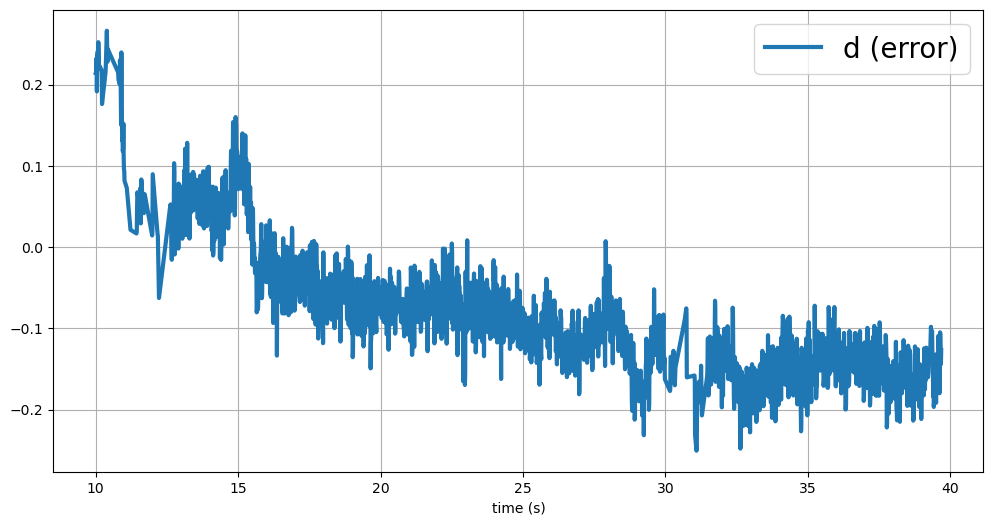

In [1603]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Assuming d_offline, t are defined elsewhere and contain at least 1001 samples

# Compute the error between the offline data (d_offline) and the desired value (0.5)
# starting from index 1000. This assumes d_offline is long enough and contains valid data.
d_err = d_offline[1000:] - 0.5

def error_plot(t, s_err, name, ax):
    # Plot the error data against time
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    # Add a legend to identify the plotted data
    ax.legend(fontsize=20)
    # Enable grid lines for better readability
    ax.grid()

# Create a figure and a single subplot for the error plot
fig, ax_d = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

# Plot the error starting from t[1000:] and corresponding d_err
error_plot(t[1000:], d_err, 'd', ax_d)

# Set the x-axis label for the time dimension
ax_d.set_xlabel('time (s)')

# Display the plot
plt.show()


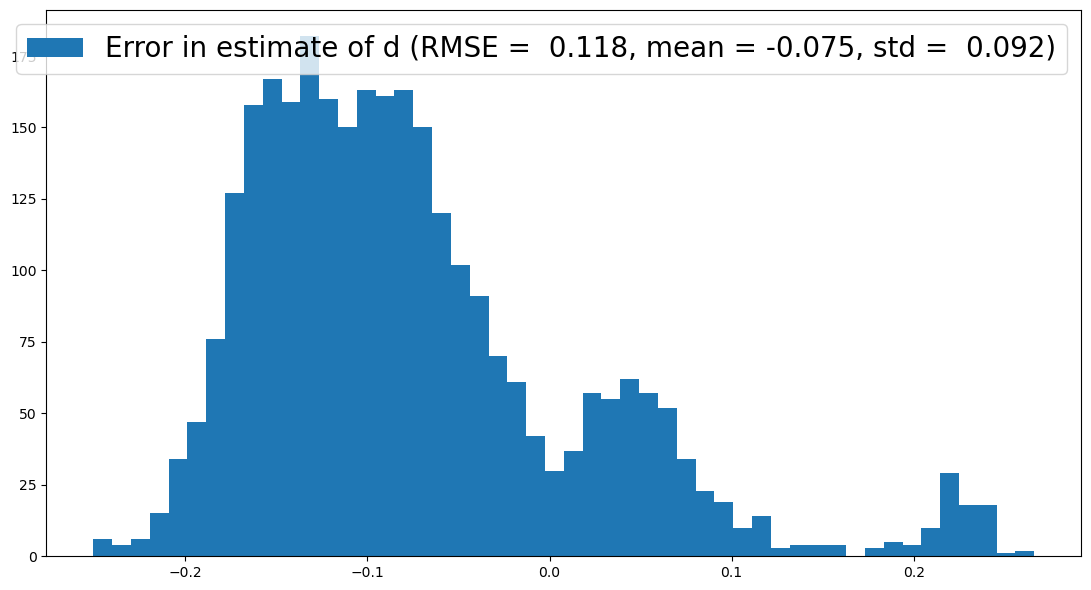

In [1604]:
import matplotlib.pyplot as plt
import numpy as np

def histogram_plot(t, s_err, name, ax):
    # Compute the RMSE, mean, and standard deviation of the error data
    rmse = np.sqrt(np.mean(s_err**2))
    mean_err = np.mean(s_err)
    std_err = np.std(s_err)

    # Construct a label that includes statistical information about the error
    label = (
        f'Error in estimate of {name} '
        f'(RMSE = {rmse:6.3f}, '
        f'mean = {mean_err:6.3f}, '
        f'std = {std_err:6.3f})'
    )

    # Plot a histogram of the error data with 50 bins
    ax.hist(s_err, 50, label=label)

    # Add a legend with a larger font size to clearly show the error statistics
    ax.legend(fontsize=20)

# Create a figure and a single subplot
fig, ax_d = plt.subplots(1, 1, figsize=(12, 6))


# Call the histogram_plot function to plot the distribution of error values
histogram_plot(t, d_err, 'd', ax_d)

# Adjust the spacing around the figure to prevent labels and titles from getting cut off
fig.tight_layout()

# Display the plot
plt.show()


# 2. Implement and test observer (moving)

## 2.1 Load and parse flight data

Load flight data.

In [1605]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
A = np.array(model['A'])
B = np.array(model['B'])
C = np.array(model['C'])
D = np.array(model['D'])
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']
r_s_eq = model['r_s_eq']

# Show model
A_str = np.array2string(A,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('A = '),
                max_line_width=np.inf)
B_str = np.array2string(B,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('B = '),
                max_line_width=np.inf)
C_str = np.array2string(C,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('C = '),
                max_line_width=np.inf)
D_str = np.array2string(D,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('D = '),
                max_line_width=np.inf)
print('STATE-SPACE MODEL')
print(f'A = {A_str}')
print(f'B = {B_str}')
print(f'C = {C_str}')
print(f'D = {D_str}')
print('PARAMETER VALUES')
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')
print(f'r_s_eq = {r_s_eq:7.4f}')

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A)))
assert(np.all(np.isfinite(B)))
assert(np.all(np.isfinite(C)))
assert(np.all(np.isfinite(D)))

STATE-SPACE MODEL
A = [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.8100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [1606]:
# Load flight data
# raw_data_drone, raw_data_mocap = load_hardware_data('calibration_default_obs_2.json')
raw_data_drone, raw_data_mocap = load_hardware_data('follower_test_moving2.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Only look at data from when the drone was actually flying
only_in_flight(data_drone)

Parse flight data. We label state estimates from the drone as `_default` to indicate that they come from the default observer.

In [1607]:
# time
t = data_drone['time']

# state estimates from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']
v_x_default = data_drone['ae483log.v_x']
v_y_default = data_drone['ae483log.v_y']
v_z_default = data_drone['ae483log.v_z']


Define parameter values.

In [1608]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


## 2.2 Apply observer for gain matrix chosen by equal weights

Implement and run your observer in the following code cell.

For each state, the result will be a numpy array (e.g., `p_x_offline`) that contains a state estimate at every time step. We label state estimates as `_offline` to indicate that they come from a custom observer that has been implemented offline. We also label the arrays of inputs (e.g., `w_x_offline`) and outputs (e.g., `n_x_offline`) as `_offline` to indicate that they are being used by a custom observer that has been implemented offline.

In [1609]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
d_offline = data_drone['ae483log.d']

# Initialize estimates
p_x = p_x_default[0]
p_y = p_y_default[0]
p_z = p_z_default[0]
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
p_x_t = 0.
p_y_t = 0.
p_z_t = 0.
r_s = 0.
r_s_minusone = 0.
r_s_minustwo = 0.

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))
p_x_t_offline = np.zeros(len(t))
p_y_t_offline = np.zeros(len(t))
p_z_t_offline = np.zeros(len(t))
r_s_offline = np.zeros(len(t))
r_s_dot_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d = d_offline[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = k_flow * (v_x / p_z_eq - w_y) - n_x
    n_y_err = k_flow * (v_y / p_z_eq + w_x) - n_y
    r_err = (p_z-p_z_eq) - (r - p_z_eq)
    d_err = r_s - d
    
    # Update estimates
    p_x += dt * v_x
    p_y += dt * v_y
    p_z += dt * (v_z - 24.182550 * r_err)
    p_x_t += dt * v_x
    p_y_t += dt * v_y
    p_z_t += dt * v_z
    # if i == 0:
    if np.abs(d) < 7.:
        r_s_minustwo = r_s_minusone
        r_s_minusone = r_s
        r_s += dt * (- d_err)
    else: 
        r_s = r_s


    r_s_dot = (3. * r_s - 4. * r_s_minusone + r_s_minustwo) / (2. * dt)


    psi += dt * w_z
    theta += dt * (w_y - 0.004880 * n_x_err)
    phi += dt * (w_x + 0.007771 * n_y_err)
    v_x += dt * (g * theta - 0.119176 * n_x_err)
    v_y += dt * (-g * phi - 0.149082 * n_y_err)
    v_z += dt * ((a_z - g) - 113.840826 * r_err)
    
    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z
    p_x_t_offline[i] = p_x_t
    p_y_t_offline[i] = p_y_t
    p_z_t_offline[i] = p_z_t
    r_s_offline[i] = r_s
    r_s_dot_offline[i] = r_s_dot


Compute error in each state estimate (relative to state estimates produced by the default observer and logged during the flight test).

In [1610]:
p_x_t_w = -1.2
p_y_t_w = 1.2
p_z_t_w = 0.

p_t_w = np.array([p_x_t_w, p_y_t_w, p_z_t_w])

p_x_t_default = p_x_default - p_x_t_w
p_y_t_default = p_y_default - p_y_t_w
p_z_t_default = p_z_default - p_z_t_w

p_x_t_w_offline = p_x_offline - p_x_t_offline
p_y_t_w_offline = p_y_offline - p_y_t_offline
p_z_t_w_offline = p_z_offline - p_z_t_offline



In [1611]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default
p_x_t_err = p_x_t_offline - p_x_t_w
p_y_t_err = p_y_t_offline - p_y_t_w
p_z_t_err = p_z_t_offline - p_z_t_w


Compare estimates with those produced by (1) the default observer and (2) the motion capture system.

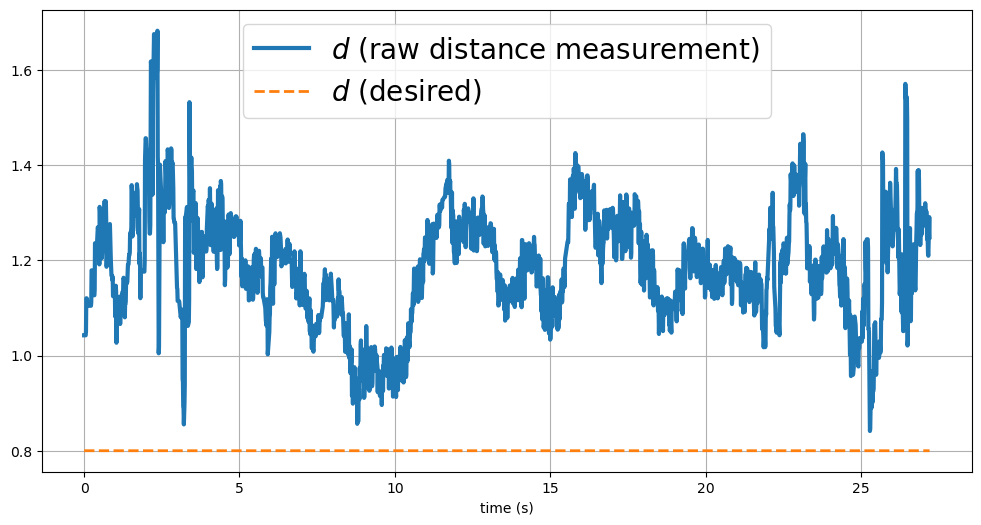

In [1612]:
def comparison_plot(t, s_offline, s_default, name, ax, s_mocap=None):
    # Plot the custom observer data (offline estimate)
    ax.plot(t, s_offline, label=f'{name} (raw distance measurement)', linewidth=3)
    
    # Plot the desired reference data as a dashed line
    ax.plot(t, s_default, '--', label=f'{name} (desired)', linewidth=2)
    
    # Optionally plot motion capture data if provided
    if s_mocap is not None:
        ax.plot(t, s_mocap, ':', label=f'{name} (mocap)', linewidth=4)
    
    # Add a legend with larger font size for better readability
    ax.legend(fontsize=20)
    
    # Set the x-axis label to indicate that the horizontal axis represents time in seconds
    ax.set_xlabel('time (s)')
    
    # Add grid lines to help visualize the data more clearly
    ax.grid()


# Create a figure with a single subplot
fig, ax_d = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

# Plot the comparison between the offline observer data (d_offline)
# and a constant desired value of 0.8, labeled as d.
comparison_plot(t, d_offline, np.ones(len(t)) * 0.8, r'$d$', ax_d)

# Display the plot
plt.show()


Plot error in each state estimate with respect to ground truth.

In [1613]:
np.sqrt(np.mean((r_s_offline[1000:] - 0.8) ** 2)), np.sqrt(np.mean((d_offline[1000:] - 0.8) ** 2))

(0.3874216748656583, 0.40849967427443695)

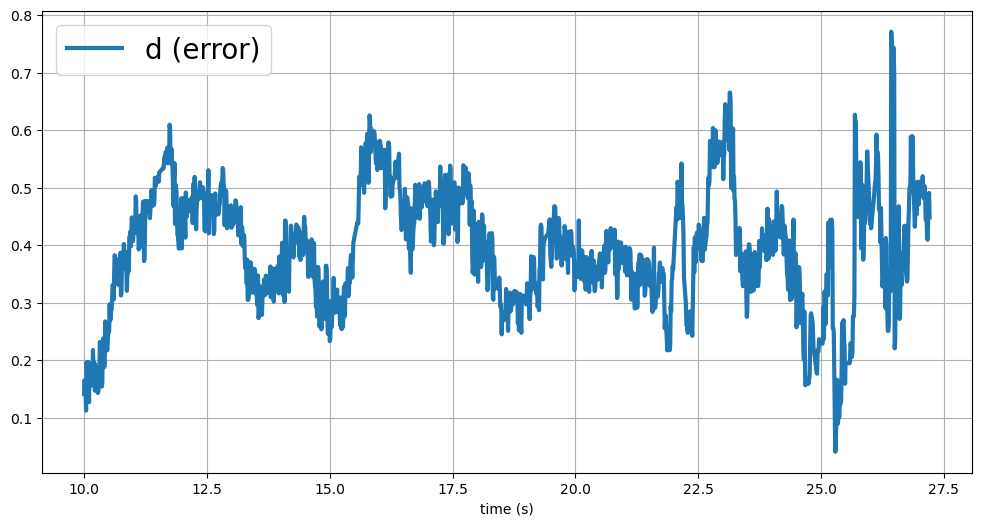

In [1614]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that t and d_offline have been defined and contain sufficient data points.

# Compute the error between the observed data and the desired value (0.8)
# starting from index 1000. This assumes that d_offline and t have at least 1001 elements.
d_err = d_offline[1000:] - 0.8

def error_plot(t, s_err, name, ax):
    # Plot the error against time
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    
    # Add a legend with a larger font size
    ax.legend(fontsize=20)
    
    # Enable grid for better readability
    ax.grid()

# Create a figure with a single subplot
fig, ax_d = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

# Plot the error starting from t[1000:] and using the computed d_err
error_plot(t[1000:], d_err, 'd', ax_d)

# Set the x-axis label to indicate the horizontal axis represents time in seconds
ax_d.set_xlabel('time (s)')

# Display the plot
plt.show()


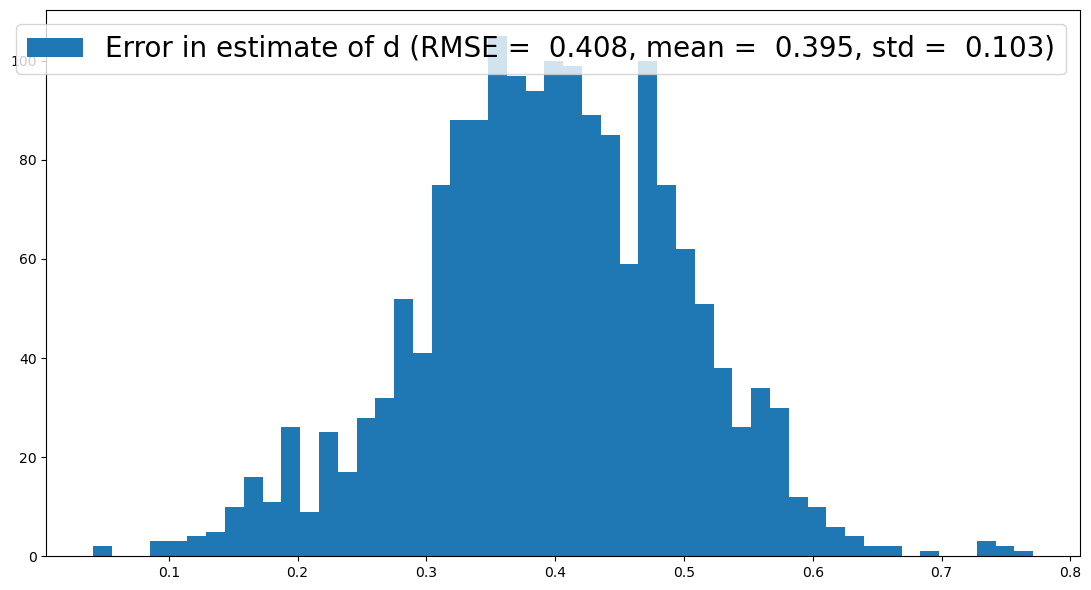

In [1615]:
import matplotlib.pyplot as plt
import numpy as np

def histogram_plot(t, s_err, name, ax):
    # Compute statistical metrics: RMSE, mean, and standard deviation
    rmse = np.sqrt(np.mean(s_err**2))
    mean_err = np.mean(s_err)
    std_err = np.std(s_err)

    # Create a label string that includes these statistics
    label = (
        f'Error in estimate of {name} '
        f'(RMSE = {rmse:6.3f}, '
        f'mean = {mean_err:6.3f}, '
        f'std = {std_err:6.3f})'
    )

    # Plot a histogram of the error data with 50 bins
    ax.hist(s_err, 50, label=label)

    # Add a legend with a larger font size for readability
    ax.legend(fontsize=20)

fig, ax_d = plt.subplots(1, 1, figsize=(12, 6))

# Call the histogram_plot function to visualize the distribution of errors
histogram_plot(t, d_err, 'd', ax_d)

# Adjust layout to prevent overlapping text
fig.tight_layout()

# Show the plot
plt.show()
